# Setup

In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Projects/AML_final_project/data_geo_hos.csv')
df.head()

,hosp_yn,death_yn,sex_female,age_0,age_18,age_50,age_65,race_native,race_asian,race_black,race_other,race_native_pacific,race_white,ethnicity_hispanic,case_month,state_fips_code,county_fips_code,case_onset_interval,symptom_status,used_bed_ratio,used_icu_ratio
0,False,False,True,False,True,False,False,False,True,False,False,False,False,True,2021-02,34,34003,0,True,0.718141,0.451212
1,False,False,True,False,True,False,False,False,False,False,True,False,False,True,2021-02,51,51700,0,True,0.746529,0.774469
2,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2021-02,51,51540,0,True,0.866410,0.755197
3,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2020-08,36,36013,0,True,0.761232,0.659091
4,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2020-12,39,39023,0,True,0.660607,0.855514


# Prepare Training- and Test Data

In [61]:
df = df.drop(columns = ['ethnicity_hispanic', 'case_month', 'state_fips_code', 'county_fips_code', 'case_onset_interval', 'symptom_status'])
df = df.replace({False: 0., True: 1.})
df = df.sample(frac=1)

data = torch.tensor(df.values, dtype = torch.float)

TRAIN_SPLIT = 0.8
train_size = int(TRAIN_SPLIT*data.shape[0])

data_train = data[:train_size]
data_test  = data[train_size:]

# Create Network Model

In [62]:
class MLP(nn.Module):
  '''implements a multilayer perceptron with sigmoid output activation
     input_dim    --> dimension of input vector (number of dataframe columns)
     hidden_dim   --> dimension of hidden layers
     hidden_depth --> number of hidden layers '''

  def __init__(self, input_dim, hidden_dim, hidden_depth):
    super(MLP, self).__init__()

    self.input_dim    = input_dim
    self.hidden_dim   = hidden_dim
    self.hidden_depth = hidden_depth

    self.layers = nn.ModuleDict()

    self.layers['fcl_in'] = nn.Linear(self.input_dim, self.hidden_dim) 

    for i in range(self.hidden_depth):
      self.layers['fcl_hidden_' + str(i)] = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.layers['fcl_out']  = nn.Linear(self.hidden_dim, 2)


  def forward(self, x):
    x = nn.functional.relu(self.layers['fcl_in'](x))

    for i in range(self.hidden_depth):
      x = nn.functional.relu(self.layers['fcl_hidden_' + str(i)](x))

    x = torch.sigmoid(self.layers['fcl_out'](x))

    return x

# Tune Hyperparameters

In [71]:
INPUT_DIM     = df.drop(columns = ['hosp_yn', 'death_yn']).shape[1]
HIDDEN_DIM    = 128
HIDDEN_DEPTH  = 5
BATCH_SIZE    = 128
N_EPOCHS      = 12
LEARNING_RATE = 0.001
LOSS          = nn.BCELoss() # (Binary Cross Entropy)

# Train Network

In [68]:
loss_train  = []
loss_test   = []

brier_train = []
brier_test  = []

# initializing network and optimizer
net = MLP(INPUT_DIM, HIDDEN_DIM, HIDDEN_DEPTH)
optim = torch.optim.SGD(net.parameters(), lr = LEARNING_RATE)

# create dataloader
train_generator = torch.utils.data.DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True)

for i in range(N_EPOCHS):
  print("epoch " + str(i+1) + ":", end=" ")

  for batch in tqdm(train_generator, leave = True, position = 0):

    optim.zero_grad()

    target     = batch[:,[0,1]]
    prediction = net(batch[:, 2:]) 

    loss = LOSS(prediction, target)
    loss.backward()

    optim.step()
  
  # record loss and brier score after every epoch
  with torch.no_grad():
    target_train     = data_train[:,[0,1]]
    target_test      = data_test[:,[0,1]]
    
    prediction_train = net(data_train[:, 2:])
    prediction_test  = net(data_test[:, 2:])
    
    loss_train.append(LOSS(prediction_train, target_train))
    loss_test.append(LOSS(prediction_test, target_test))

    brier_train.append([brier_score_loss(target_train[:,0], prediction_train[:,0]), brier_score_loss(target_train[:,1], prediction_train[:,1])])
    brier_test.append([brier_score_loss(target_test[:,0], prediction_test[:,0]), brier_score_loss(target_test[:,1], prediction_test[:,1])])


epoch 1: 

100%|██████████| 19697/19697 [00:50<00:00, 389.02it/s]


epoch 2: 

100%|██████████| 19697/19697 [00:50<00:00, 393.32it/s]


epoch 3: 

100%|██████████| 19697/19697 [00:49<00:00, 399.30it/s]


epoch 4: 

100%|██████████| 19697/19697 [00:50<00:00, 390.65it/s]


epoch 5: 

100%|██████████| 19697/19697 [00:50<00:00, 391.92it/s]


epoch 6: 

100%|██████████| 19697/19697 [00:49<00:00, 394.46it/s]


epoch 7: 

100%|██████████| 19697/19697 [00:50<00:00, 391.35it/s]


epoch 8: 

100%|██████████| 19697/19697 [00:50<00:00, 393.39it/s]


epoch 9: 

100%|██████████| 19697/19697 [00:51<00:00, 385.16it/s]


epoch 10: 

100%|██████████| 19697/19697 [00:51<00:00, 384.18it/s]


epoch 11: 

100%|██████████| 19697/19697 [00:51<00:00, 383.14it/s]


epoch 12: 

100%|██████████| 19697/19697 [00:51<00:00, 379.68it/s]


# Evaluate Performance

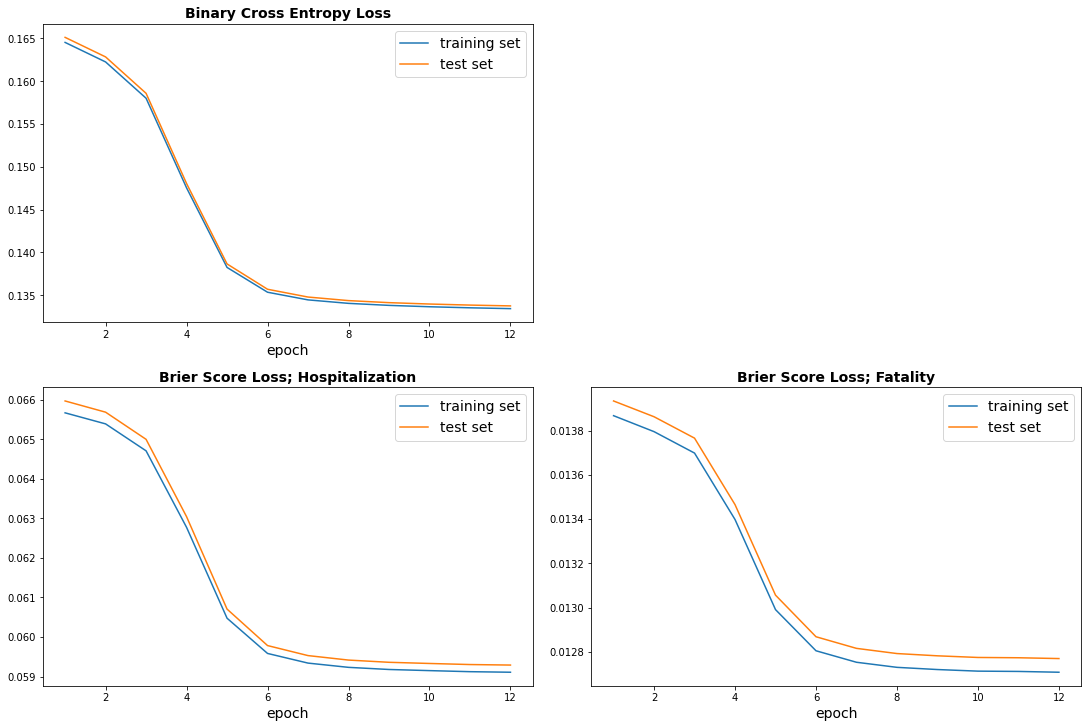

final cross entropy loss on test set:  0.13375506
final brier score loss on test set (hospitalization):  0.05929059854515798
final brier score loss on test set (fatality):  0.012769281952133732


In [69]:
loss_train  = np.array(loss_train)
loss_test   = np.array(loss_test)
brier_train = np.array(brier_train)
brier_test  = np.array(brier_test)

x = list(range(1, N_EPOCHS +1))

fig, ax = plt.subplots(2,2, figsize = (15, 10), constrained_layout=True)

ax[0][0].plot(x, loss_train, label = "training set")
ax[0][0].plot(x, loss_test, label = "test set")
ax[0][0].set_xlabel("epoch", fontsize = 14)
ax[0][0].set_title("Binary Cross Entropy Loss", fontsize = 14, fontweight="bold")
ax[0][0].legend(fontsize = 14)

ax[0][1].axis("off")

ax[1][0].plot(x, brier_train[:,0], label = "training set")
ax[1][0].plot(x, brier_test[:,0], label = "test set")
ax[1][0].set_xlabel("epoch", fontsize = 14)
ax[1][0].set_title("Brier Score Loss; Hospitalization", fontsize = 14, fontweight="bold")
ax[1][0].legend(fontsize = 14)

ax[1][1].plot(x, brier_train[:,1], label = "training set")
ax[1][1].plot(x, brier_test[:,1], label = "test set")
ax[1][1].set_xlabel("epoch", fontsize = 14)
ax[1][1].set_title("Brier Score Loss; Fatality", fontsize = 14, fontweight="bold")
ax[1][1].legend(fontsize = 14)

plt.show()

print("final cross entropy loss on test set: ", loss_test[-1])
print("final brier score loss on test set (hospitalization): ", brier_test[-1,0])
print("final brier score loss on test set (fatality): ", brier_test[-1,1])

In [70]:
# check wether the network produces reasonable results for simple test cases:
# case_1 -> male, <18 years old, white
# case_2 -> male, 65+ years old, white
case_1 = torch.tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.718141, 0.451212]) # young
case_2 = torch.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.718141, 0.451212]) # old

hosp_1, fata_1 = net(case_1)
hosp_2, fata_2 = net(case_2)

hosp_1 = round(100*hosp_1.item(), 2)
fata_1 = round(100*fata_1.item(), 2)
hosp_2 = round(100*hosp_2.item(), 2)
fata_2 = round(100*fata_2.item(), 2)

print("case_1 (young)")
print("probability of hospitalization: ", hosp_1, "%")
print("probability of death: ", fata_1, "%")
print("\n")
print("case_2 (old)")
print("probability of hospitalization: ", hosp_2, "%")
print("probability of death: ", fata_2, "%")

case_1 (young)
probability of hospitalization:  2.56 %
probability of death:  0.03 %


case_2 (old)
probability of hospitalization:  30.03 %
probability of death:  12.11 %
